This script solves the inverse problem to find the heat diffusion D of a heat equation.

In [1]:
import torch
import numpy as np
import pytorch_lightning as pl
from timeit import default_timer as timer

from neural_diff_eq.problem import Variable
from neural_diff_eq.setting import Setting
from neural_diff_eq.problem.domain import (Rectangle,
                                           Interval)
from neural_diff_eq.problem.condition import (DirichletCondition,
                                              DiffEqCondition,
                                              DataCondition)
from neural_diff_eq.models.fcn import SimpleFCN
from neural_diff_eq.models.inversemodel import InverseModel 
from neural_diff_eq import PINNModule
from neural_diff_eq.utils import laplacian, gradient
from neural_diff_eq.utils.fdm import FDM, create_validation_data
from neural_diff_eq.utils.plot import Plotter
from neural_diff_eq.setting import Setting

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

The first steps are like the forward problem. Define some parameters
and the variables of the problem.

In [2]:
w, h = 10, 10
t0, tend = 0, 3
temp_hot = 100

In [3]:
x = Variable(name='x',
             order=2,
             domain=Rectangle(corner_dl=[0, 0],
                              corner_dr=[w, 0],
                              corner_tl=[0, h]),
             train_conditions={},
             val_conditions={})
t = Variable(name='t',
             order=1,
             domain=Interval(low_bound=0,
                             up_bound=tend),
             train_conditions={},
             val_conditions={})

Now we have the first different step. With the pde we want to find the parameter
D. This parameter will later be added to our model. The pde condition gets now an additional input: params. This input contains all learnable paramters of the model.

We also need to tell the condition that we now want to solve an inverse problem so we set 
inverse_problem=True, in DiffEqCondition.

In [4]:
norm = torch.nn.MSELoss()
def pde(u, input, params):
    return gradient(u, input['t']) - params['D']*laplacian(u, input['x'])

train_cond = DiffEqCondition(pde=pde,
                             name='pde',
                             norm=norm,
                             sampling_strategy='random',
                             weight=1.0,
                             dataset_size=500,
                             data_plot_variables=('x','t'),
                             inverse_problem=True)


Instead of adding addtional conditions for the inital and boundary values we now create a DataCondition, by using a FDM to solve the forward problem.

In [5]:
D_list = [2] # This D is the value we will later try to find!
domain_dic = {'x': [[0,w], [0,h]]}
dx, dy = 0.5, 0.5
step_width_dict = {'x': [dx, dy]}
time_interval = [t0, tend]
def inital_condition(input):
    return temp_hot * np.sin(np.pi/w*input['x'][:,:1]) * np.sin(np.pi/h*input['x'][:,1:]) 
fdm_start = timer()
domain, time, u = FDM(domain_dic, step_width_dict, time_interval, 
                      D_list, inital_condition)
fdm_end = timer()
print('Time for FDM-Solution:', fdm_end-fdm_start)

data_x, data_u = create_validation_data(domain, time, u, D_list, D_is_input = False)

Time for FDM-Solution: 0.008321547880768776


We dont want to use all points of the FDM-solution, therefore for now pick only 5000 random values 

In [6]:
index = np.random.choice(len(data_u), 5000, replace=False)
data_u = data_u[index]
for name in data_x:
    data_x[name] = data_x[name][index]

With these points we now create a DataCondition

In [7]:
data_cond = DataCondition(data_x=data_x,
                         data_u=data_u,
                         name='data_cond',
                         norm=norm)

In [8]:
setup = Setting(variables=(x, t),
                train_conditions={'pde': train_cond, 'data': data_cond},
                val_conditions={},
                n_iterations=1000,
                num_workers=0)

In the next step, we tell our model which parameter it has to train.
For this we use the class InverseModel. 
As an input, we first give an any neural network that we want to use, to approximate the solution.
The second input is a dictionary that contains all additional parameters, that we want to find. We have to specify a name and either an initial guess or the dimension of the parameter.

In [12]:
solver = PINNModule(model=InverseModel(
                            model=SimpleFCN(input_dim=3, depth=3, width=20),
                            params={'D': torch.zeros(1)}),
                    optimizer=torch.optim.Adam, # Start with adam
                    lr=1e-2
                    )

In [13]:
trainer = pl.Trainer(gpus=1,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     check_val_every_n_epoch=100,
                     log_every_n_steps=1,
                     max_epochs=3,
                     checkpoint_callback=False
                     )

trainer.fit(solver, setup)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type         | Params
---------------------------------------
0 | model | InverseModel | 1.4 K 
---------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

After the trainig with adam we check the current value of D:

In [14]:
solver.model.get_parameters()

OrderedDict([('D',
              Parameter containing:
              tensor([1.9537], requires_grad=True))])

In [15]:
# switch to lbfgs
solver.lr = 0.05
solver.optim_params = {'max_iter': 1, 'history_size': 100}
solver.optimizer = torch.optim.LBFGS
trainer = pl.Trainer(gpus=1,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     check_val_every_n_epoch=100,
                     log_every_n_steps=100,
                     max_epochs=2,
                     checkpoint_callback=False
                     )

trainer.fit(solver, setup)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type         | Params
---------------------------------------
0 | model | InverseModel | 1.4 K 
---------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a 

Training: 0it [00:00, ?it/s]

And again check the value of D. It is pretty close to D = 2, what we used in the FDM 

In [16]:
solver.model.get_parameters()

OrderedDict([('D',
              Parameter containing:
              tensor([2.0058], requires_grad=True))])

Not only did we find D, the neural network also learned the solution of our problem:

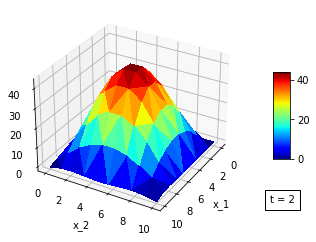

In [17]:
from neural_diff_eq.utils.plot import _plot
fig = _plot(solver.model, plot_variables=x, points=100, dic_for_other_variables={'t': 2})